---
title: "DATA210P - Final Project: Quantized autoencoder (QAE) intrusion detection system for anomaly detection in IoT devices using RT-IoT2022 dataset"
author: "Joe Nguyen"
format:
  pdf:
    number-sections: true
    fig-pos: "H"
    toc: true
    toc-depth: 3
    df-print: pandas
    keep-tex: true
    geometry:
    - margin=1in
    header-includes:
      - \KOMAoption{captions}{tableheading}
      - \usepackage{textcomp}
    include-in-header:
      text: |
        \usepackage[section]{placeins}
execute:
  echo: false
  warning: false
  message: false
fig-width: 6
fig-height: 4
dpi: 300
---

# Project Overview

## Introduction

The widespread adoption of Internet of Things (IoT) technologies across sectors such as healthcare, manufacturing, and agriculture has increased dependence on continuous network connectivity and large-scale data exchange. This expanded connectivity significantly enlarges the attack surface, making IoT devices attractive targets for cybercriminals who can exploit vulnerable endpoints to compromise other systems operating within the same network infrastructure (Sharmila and Nagapadma, 2023). The financial consequences of such attacks continue to escalate. According to the IBM Cost of a Data Breach Report 2025, the global average cost of a data breach is USD 4.44 million, reflecting the persistent economic impact of increasingly sophisticated cyber threats, particularly those involving AI-driven and ungoverned systems (IBM Security, 2025). High-profile incidents further demonstrate the severity of these risks. In 2021, the Verkada breach exposed live video feeds from approximately 150 million surveillance cameras, while another attack in the same year enabled an adversary to manipulate chemical levels at a water treatment facility in Florida. These incidents highlight the growing prevalence and potential consequences of anomaly-based cyberattacks within IoT infrastructures, underscoring the urgent need for robust and efficient anomaly detection mechanisms as IoT deployments continue to expand (Sharmila and Nagapadma, 2023).

This project aims to replicate and extend the findings of Sharmila and Nagapadma (2023) by evaluating the effectiveness of autoencoder-based anomaly detection for identifying malicious activity in IoT network traffic. Building on their approach, we focus on systematic model selection, rigorous evaluation of predictive and generalization performance, and interpretation of the relationship between learned representations and key traffic features. Given the heterogeneity of IoT network behavior and the variability in traffic patterns across devices, anomaly detection requires models capable of learning device-specific normal behavior. Consistent with prior work, we employ autoencoder architectures trained exclusively on benign network traffic, under the assumption that anomalous traffic will yield higher reconstruction error. The analysis is conducted using real-time IoT network traffic collected from four representative devices—ThingSpeak-LED, MQTT-Temp, Amazon Alexa, and Wipro Bulb—allowing us to assess model robustness across diverse IoT operating profiles.

Recent intrusion detection systems (IDS) for IoT environments increasingly adopt unsupervised learning approaches, particularly anomaly detection, to identify rare deviations from normal network behavior. As summarized by Sharmila and Nagapadma (2023), this paradigm is especially important in IoT infrastructures, where anomalous activity can lead to severe operational and environmental consequences. However, the authors note that progress in this area has been constrained by the limited availability of realistic IoT-specific network traffic datasets, which complicates reliable anomaly detection. To address this challenge, their study emphasizes the generation and use of network traces collected from real-time IoT devices that capture both benign and attack behaviors.

Sharmila and Nagapadma (2023) further highlight that deploying AI-based IDS frameworks on IoT devices presents significant challenges due to constrained computational resources, including limited memory, processing capability, and energy availability. As a result, conventional deep learning models are often impractical without optimization. Their work underscores the importance of model optimization techniques—such as network pruning and numerical quantization—to reduce model size and computational overhead while preserving detection performance. These strategies enable more efficient inference, lower energy consumption, and improved feasibility of deploying anomaly detection models on resource-constrained IoT devices.

## Objectives:

1) Identify traffic features that differ significantly between benign and attack traffic; assess effect sizes and collinearity. 

2) Train and evaluate intrusion-detection models for attack detection and attack-type classification under class imbalance.
- Logistic Regression
- Autoencoder

## Data Source & Import: 

The RT-IoT2022, a proprietary dataset derived from a real-time IoT infrastructure, is introduced as a comprehensive resource integrating a diverse range of IoT devices and sophisticated network attack methodologies. This dataset encompasses both normal and adversarial network behaviours, providing a general representation of real-world scenarios. Incorporating data from IoT devices such as ThingSpeak-LED, Wipro-Bulb, and MQTT-Temp, as well as simulated attack scenarios involving Brute-Force SSH attacks, DDoS attacks using Hping and Slowloris, and Nmap patterns, RT-IoT2022 offers a detailed perspective on the complex nature of network traffic. The bidirectional attributes of network traffic are meticulously captured using the Zeek network monitoring tool and the Flowmeter plugin. Researchers can leverage the RT-IoT2022 dataset to advance the capabilities of Intrusion Detection Systems (IDS), fostering the development of robust and adaptive security solutions for real-time IoT networks.

Source Link: https://archive.ics.uci.edu/dataset/942/rt-iot2022

Import UCI ML Repo and load dataset.

In [56]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
rt_iot2022 = fetch_ucirepo(id=942) 
  
# data (as pandas dataframes) 
X = rt_iot2022.data.features 
y = rt_iot2022.data.targets 

## Data Dictionary:
From data source:

1) **Outcome (Response) Variable**: Attack_type (categorical)
    - Attack patterns:
        - DOS_SYN_Hping
        - ARP_poisioning
        - NMAP_UDP_SCAN
        - NMAP_XMAS_TREE_SCAN
        - NMAP_OS_DETECTION
        - NMAP_TCP_scan
        - DDOS_Slowloris
        - Metasploit_Brute_Force_SSH
        - NMAP_FIN_SCAN
    - Normal Patterns:
        - MQTT
        - Thing_speak
        - Wipro_bulb_Dataset
        
2) **Predictor (Feature) Variables**:

## Initial EDA of the dataset:

In [57]:
import pandas as pd

print("X shape:", X.shape)
print("y shape:", y.shape)
print("X columns:", list(X.columns)[:10], "...")

print("\nTargets info:")
print(type(y))
print(y.head())

X shape: (123117, 83)
y shape: (123117, 1)
X columns: ['id.orig_p', 'id.resp_p', 'proto', 'service', 'flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot', 'bwd_data_pkts_tot', 'fwd_pkts_per_sec'] ...

Targets info:
<class 'pandas.DataFrame'>
    Attack_type
0  MQTT_Publish
1  MQTT_Publish
2  MQTT_Publish
3  MQTT_Publish
4  MQTT_Publish


## Inspect targets (y):

- Ensures y is a Series (not a 1-col df)
- Prints target name and value counts

In [58]:
import pandas as pd
from src.utils import show_table

# If y is a DataFrame, extract the Series
y_ser = y.iloc[:, 0] if isinstance(y, pd.DataFrame) else y

print("Target name:", y_ser.name)

# Quarto/Jupyter-friendly: return a DataFrame as the last expression in the cell
show_table(
    y_ser.value_counts(dropna=False)
         .rename_axis("Attack_type")
         .to_frame("count"),
    max_rows=50
)


Target name: Attack_type


,count
Attack_type,
DOS_SYN_Hping,94659
Thing_Speak,8108
ARP_poisioning,7750
MQTT_Publish,4146
NMAP_UDP_SCAN,2590
NMAP_XMAS_TREE_SCAN,2010
NMAP_OS_DETECTION,2000
NMAP_TCP_scan,1002
DDOS_Slowloris,534


## Create binary label (y_bin):

- Converts multiclass Attack_type into binary: 0 = normal, 1 = attack
- Normal classes are the benign IoT device activity buckets: Thing_Speak, MQTT_Publish, and Wipro_bulb

In [59]:
from src.utils import show_table

NORMAL_CLASSES = {"Thing_Speak", "MQTT_Publish", "Wipro_bulb"}

# 1 = attack, 0 = normal
y_bin = (~y_ser.isin(NORMAL_CLASSES)).astype(int).rename("is_attack")

# Build a single clean summary table
class_counts = y_bin.value_counts().sort_index().rename_axis("class").to_frame("count")
class_counts["rate"] = class_counts["count"] / class_counts["count"].sum()

print("Binary label distribution (0=normal, 1=attack)")

show_table(class_counts)


Binary label distribution (0=normal, 1=attack)


,count,rate
class,,
0,12507,0.101586
1,110610,0.898414


## Data Validation:

- Import validate_binary_Xy(X, y) to validate that:
    - X is a DataFrame, y is a Series
    - Same number of rows
    - y has exactly 2 classes
    - Reports missing values, duplicates, non-numeric features, constant columns
- Import class_balance(y) to return counts & rates per classe as a DataFrame

In [60]:
import pandas as pd
from src.utils import as_table, show_table
from src.data_validation import validate_binary_Xy

# Ensure y_bin is a Series
y_bin_ser = y_bin.iloc[:, 0] if isinstance(y_bin, pd.DataFrame) else y_bin

validation_report = validate_binary_Xy(X, y_bin_ser)

# Convert dataclass → 1-row DataFrame
report_df = as_table(validation_report)

# For a cleaner report layout: transpose to key-value format
report_kv = report_df.T.rename(columns={0: "value"})

print("Validation report (X, y)")

show_table(report_kv)


Validation report (X, y)


,value
n_rows,123117
n_features,83
n_missing_total,0
n_duplicate_rows,5202
non_numeric_feature_cols,"[proto, service]"
constant_feature_cols,[bwd_URG_flag_count]


In [61]:
from src.preprocessing import PrepConfig, prepare_X
from src.utils import show_table

prep_cfg = PrepConfig(
    drop_cols=(),
    drop_non_numeric=True,
    drop_constant=True,
    impute_strategy="median",
)

Xp, feature_cols = prepare_X(X, prep_cfg)

print("Dropped non-numeric feature columns:")
print(validation_report.non_numeric_feature_cols)
print("Dropped constant feature columns:")
print(validation_report.constant_feature_cols)


print("\nPreprocessed feature matrix summary:")
show_table(
    pd.DataFrame([{
        "n_rows": Xp.shape[0],
        "n_features": Xp.shape[1],
        "missing_cells_after": int(Xp.isna().sum().sum()),
    }])
)

Dropped non-numeric feature columns:
['proto', 'service']
Dropped constant feature columns:
['bwd_URG_flag_count']

Preprocessed feature matrix summary:


,n_rows,n_features,missing_cells_after
0,123117,80,0


In [62]:
print("Total duplicates in full dataset:",
      Xp.duplicated().sum())

Total duplicates in full dataset: 5202


In [63]:
# Combine features + target temporarily
full_df = Xp.copy()
full_df["target"] = y_bin.values

# Drop duplicate feature rows
full_df_nodup = full_df.drop_duplicates(subset=Xp.columns)

print("Rows before:", full_df.shape[0])
print("Rows after removing duplicates:", full_df_nodup.shape[0])

# Separate back out
Xp_nodup = full_df_nodup.drop(columns="target")
y_nodup = full_df_nodup["target"]

Rows before: 123117
Rows after removing duplicates: 117915


In [64]:
from src.splits import SplitConfig, stratified_split
from src.utils import show_table

split_cfg = SplitConfig(test_size=0.2, val_size=0.2, random_state=42)

X_train, y_train, X_val, y_val, X_test, y_test = stratified_split(Xp_nodup, y_nodup, split_cfg)

# Build split summary table
split_summary = pd.DataFrame([
    {"split": "train", "n_rows": X_train.shape[0], "n_features": X_train.shape[1]},
    {"split": "val",   "n_rows": X_val.shape[0],   "n_features": X_val.shape[1]},
    {"split": "test",  "n_rows": X_test.shape[0],  "n_features": X_test.shape[1]},
])

print("Train / Validation / Test split summary")

show_table(split_summary)


Train / Validation / Test split summary


,split,n_rows,n_features
0,train,75465,80
1,val,18867,80
2,test,23583,80


In [65]:
print("Duplicate rows between train and test:")
print(pd.merge(X_train, X_test).shape[0])

Duplicate rows between train and test:
0


In [66]:
from src.preprocessing import fit_scaler, transform_with_scaler
from src.utils import show_table

# Fit only on training data (prevents leakage)
scaler = fit_scaler(X_train)

# Transform all splits
X_train_s = transform_with_scaler(scaler, X_train)
X_val_s   = transform_with_scaler(scaler, X_val)
X_test_s  = transform_with_scaler(scaler, X_test)


In [67]:
import numpy as np
from src.utils import show_table

print("Standardization sanity check (all splits)")

def scaling_stats(X_scaled, split_name):
    return {
        "split": split_name,
        "mean_abs_mean": float(np.abs(X_scaled.mean(axis=0)).mean()),
        "mean_std": float(X_scaled.std(axis=0).mean())
    }

scaling_summary = pd.DataFrame([
    scaling_stats(X_train_s, "train"),
    scaling_stats(X_val_s,   "val"),
    scaling_stats(X_test_s,  "test"),
])

show_table(scaling_summary)


Standardization sanity check (all splits)


,split,mean_abs_mean,mean_std
0,train,3.608633e-17,1.000000
1,val,7.795284e-03,0.755738
2,test,8.306794e-03,0.681777


In [68]:
from src.modeling_logreg import LogRegConfig, train_logreg
from src.utils import as_table, show_table

logreg_cfg = LogRegConfig(class_weight="balanced")  # set to None for unweighted baseline

# Show config (dataclass -> 1-row df -> key/value view)
cfg_df = as_table(logreg_cfg).T.rename(columns={0: "value"})
show_table(cfg_df)

# Train
model = train_logreg(X_train_s, y_train.to_numpy(), logreg_cfg)

# Minimal fit summary (handy in reports)
fit_summary = {
    "n_train_rows": X_train_s.shape[0],
    "n_features": X_train_s.shape[1],
    "class_weight": logreg_cfg.class_weight,
}
show_table(pd.DataFrame([fit_summary]))


,n_train_rows,n_features,class_weight
0,75465,80,balanced


In [69]:
from src.modeling_logreg import proba_attack, tune_threshold_max_f1_attack
from src.utils import show_table

# Get validation probabilities
val_score = proba_attack(model, X_val_s)

# Tune threshold
best_thr, best_val_f1 = tune_threshold_max_f1_attack(
    y_val.to_numpy(),
    val_score
)

# Display result
show_table(
    pd.DataFrame([{
        "best_threshold": best_thr,
        "best_val_f1_attack": best_val_f1
    }])
)


,best_threshold,best_val_f1_attack
0,0.064,0.994855


In [70]:
show_table(
    pd.DataFrame({
        "val_prob_min": [val_score.min()],
        "val_prob_max": [val_score.max()],
        "val_prob_mean": [val_score.mean()]
    })
)

,val_prob_min,val_prob_max,val_prob_mean
0,1.401693e-222,1.0,0.873471


In [71]:
from src.metrics import evaluate_scores
from src.utils import as_table, show_table

print("Test set evaluation (Logistic Regression baseline)")

# Get test probabilities
test_score = proba_attack(model, X_test_s)

# Evaluate
metrics = evaluate_scores(
    y_test.to_numpy(),
    test_score,
    threshold=best_thr
)

# Convert dataclass -> vertical key/value table
metrics_df = as_table(metrics).T.rename(columns={0: "value"})

show_table(metrics_df)


Test set evaluation (Logistic Regression baseline)


,value
threshold,0.064000
precision_attack,0.990716
recall_attack,0.997639
f1_attack,0.994166
f1_macro,0.970462
roc_auc,0.997183
pr_auc,0.999650
tn,2205.000000
fp,198.000000
fn,50.000000


In [72]:
from src.utils import show_table

print("Confusion matrix (test set)")

cm_df = pd.DataFrame(
    [[metrics.tn, metrics.fp],
     [metrics.fn, metrics.tp]],
    index=["true_normal (0)", "true_attack (1)"],
    columns=["pred_normal (0)", "pred_attack (1)"]
)

show_table(cm_df)

Confusion matrix (test set)


,pred_normal (0),pred_attack (1)
true_normal (0),2205,198
true_attack (1),50,21130


In [ ]:
from sklearn.linear_model import LogisticRegression

unweighted = LogisticRegression(max_iter=2000)
unweighted.fit(X_train_s, y_train)

test_score_unweighted = unweighted.predict_proba(X_test_s)[:,1]

from sklearn.metrics import roc_auc_score
print("ROC AUC (unweighted):",
      roc_auc_score(y_test, test_score_unweighted))


ROC AUC (unweighted): 0.9958269820891968


In [ ]:
import numpy as np

corrs = np.abs(np.corrcoef(X_train_s.T, y_train)[-1, :-1])
print("Max feature-target correlation:", corrs.max())


Max feature-target correlation: 0.6306735063121721


ROC curve (test set)


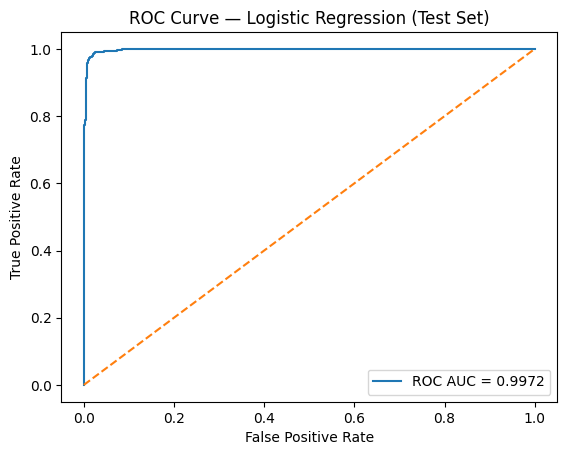

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

print("ROC curve (test set)")

fpr, tpr, _ = roc_curve(y_test.to_numpy(), test_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")  # diagonal baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression (Test Set)")
plt.legend(loc="lower right")
plt.show()


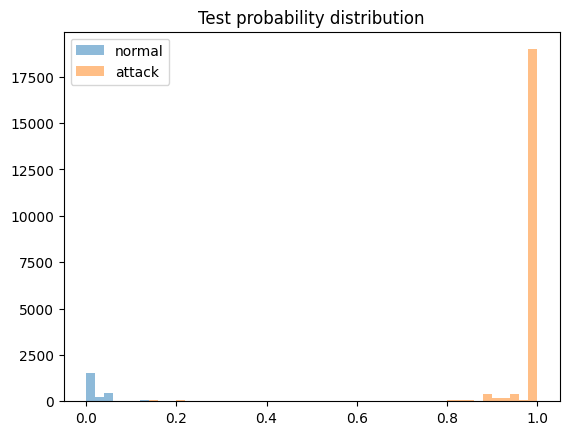

In [78]:
import matplotlib.pyplot as plt

plt.hist(test_score[y_test==0], bins=50, alpha=0.5, label="normal")
plt.hist(test_score[y_test==1], bins=50, alpha=0.5, label="attack")
plt.legend()
plt.title("Test probability distribution")
plt.show()
